In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from numba.typed import Dict
from numba.core import types

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.models.aln import ALNModel

from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, oc_aln, cost_functions

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1"] = 0.0
weights["w_1T"] = 0.0
weights["w_1D"] = 0.0

def plot_control(c, s, dur, dt, filename=None, title=None):
    fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
    time_array = np.arange(0, dur+dt, dt)

    cmax = np.amax(np.abs(c))
    y1lim = [-cmax* 1.1, cmax* 1.1]

    for n in range(N):
        ax[0].plot(time_array, s[n,0,:], color="red")
        ax[1].plot(time_array, c[n,0,:], color="red")
        ax[1].plot(time_array, c[n,1,:], color="blue")

    ax[0].set_xlim(0, dur)

    ax[1].set_ylim(y1lim)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return

# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state

# This function sets the initial state of a model to specific values
def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

# This function reads the complete state of the EIF model
def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state

def getperiod(data, dt):

    for i_d,d in enumerate(data):
        ps = np.abs(np.fft.fft(d))
        ps_plot = ps[:int(len(ps)/2)] / (len(ps)/2)
        ps_plot[0] = 0.
        fr = np.linspace(0,1./(2.*dt),len(ps_plot))

    maxfreqind = np.where(ps_plot == max(ps_plot[1:]))

    return (1./fr[maxfreqind])[0]

def adjust_weight(model_controlled, weight):
    coc = cost_functions.control_strength_cost(model_controlled.control.copy(), weights, dt)
    fsync = (model_controlled.compute_total_cost() - coc)/weight
    weight = (-1e-12 - coc)/fsync # adjust weight such that cost remains negative
    print("weight = ", weight)
    model_controlled.weights["w_f_osc"] = weight
    return weight

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data = dict()
coords = [1.9, 1.5]

data = dict()
data["coordinates"] = coords
data["control"] = [None, None]
data["state"] = [None, None]
data["init_state"] = [None, None]
data["energy_input"] = np.zeros((2))
data["Fourier_cost"] = np.zeros((2))
data["weights"] = np.zeros((2))

N = 1
model = ALNModel()
dt = model.params.dt

In [5]:
model = ALNModel()
testd = 2.*1e4
model.params.duration = testd
model.params.mue_ext_mean = data["coordinates"][0]
model.params.mui_ext_mean = data["coordinates"][1]

test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
test_input[0,int(2000/dt):int(2010/dt)] = -1.
model.params["ext_exc_current"] = test_input
model.params["ext_inh_current"] = test_input

model.run()
data["init_state"][0] = getfinalstate(model)

test_input[0,int(2000/dt):int(2010/dt)] = 0.
model.params["ext_exc_current"] = test_input
model.params["ext_inh_current"] = test_input

model.run()
data["init_state"][1] = getfinalstate(model)

natural_period = getperiod([model.rates_exc[0,int(1000/dt):]], dt)

In [7]:
controlmat = np.zeros((N,4))
controlmat[0,0] = 1

costmat = np.zeros((N, 3))
costmat[:,0] = 1.

duration = 1000.

max_cntrl = 5
pr = np.arange(0,101,10)

In [34]:
data["weights"][0] = 1e6

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -90044.60584676077
Final cost : -851712.1532634712
Compute control for a deterministic system
Cost in iteration 0: -851712.1532634712
Final cost : -922808.8810897998
weight =  1169.6570290367624
Compute control for a deterministic system
Cost in iteration 0: -922808.8810897998
Converged in iteration 1 with cost -922808.8810897998
Final cost : -922808.8810897998


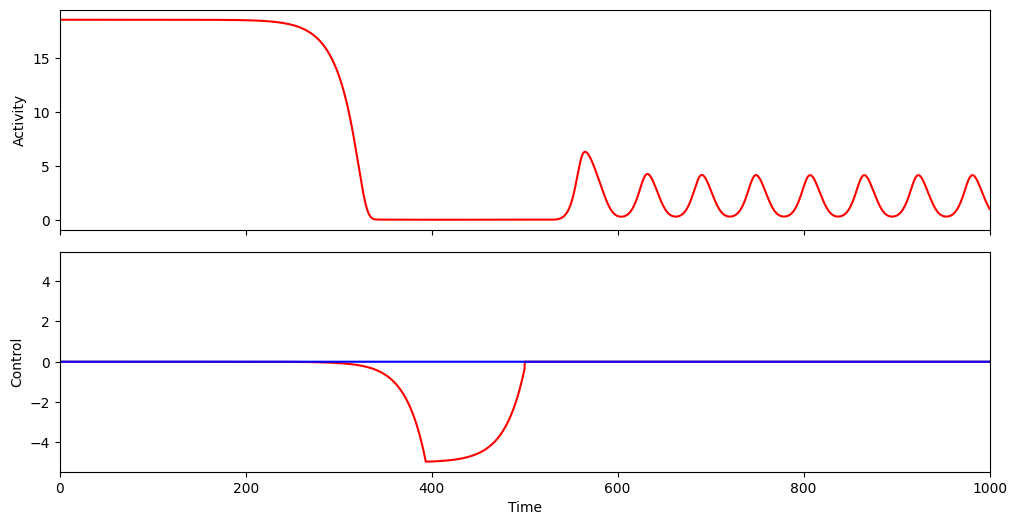

In [29]:
ci = 0 # up to osc task

model = ALNModel()
setinitstate(model, data["init_state"][0])
model.params["mue_ext_mean"] =  data["coordinates"][0]
model.params["mui_ext_mean"] =  data["coordinates"][1]
model.params.duration = duration

model.run()

int0 = 1000
int1 = 6000

model_controlled = oc_aln.OcAln(model, natural_period, print_array=pr, cost_interval=(int1,None), control_interval=(int0, int1-1000), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = data["weights"][ci]

model_controlled.maximum_control_strength = max_cntrl
model_controlled.optimize(1)

model_controlled.grad_method = 0

for k in [0]:
    model_controlled.zero_step_encountered = False
    model_controlled.step = 10**(k)
    model_controlled.optimize(4)

for l in range(1):
    data["weights"][ci] = adjust_weight(model_controlled, data["weights"][ci])
    model_controlled.zero_step_encountered = False
    model_controlled.step = 10**(-2)
    model_controlled.optimize(4)

data["control"][ci] = model_controlled.control.copy()
data["state"][ci] = model_controlled.get_xs()

data["energy_input"][ci] = cost_functions.control_strength_cost(data["control"][ci], weights, dt)
data["Fourier_cost"][ci] = (model_controlled.compute_total_cost() - data["energy_input"][ci])/data["weights"][ci]
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: 158.5093532477523
Final cost : 136.32765305650645
weight =  366.7028057254869
Compute control for a deterministic system
Cost in iteration 0: 136.32765305650645
Final cost : 135.8576866456008
weight =  614.2202946153401
Compute control for a deterministic system
Cost in iteration 0: 135.8576866456008
Final cost : -124.43652148797605
weight =  235.34578516784592
Compute control for a deterministic system
Cost in iteration 0: -124.43652148797605
Converged in iteration 4 with cost -188.58849889419312
Final cost : -188.58849889419312
weight =  13.520547317073602
Compute control for a deterministic system
Cost in iteration 0: -188.58849889419312
Final cost : -188.58849889419312
weight =  0.7767515344404897
Compute control for a deterministic system
Cost in iteration 0: -188.58849889419312
Final cost : -188.58849889419312
weight =  0.04462415108697267
Compute control for a determini

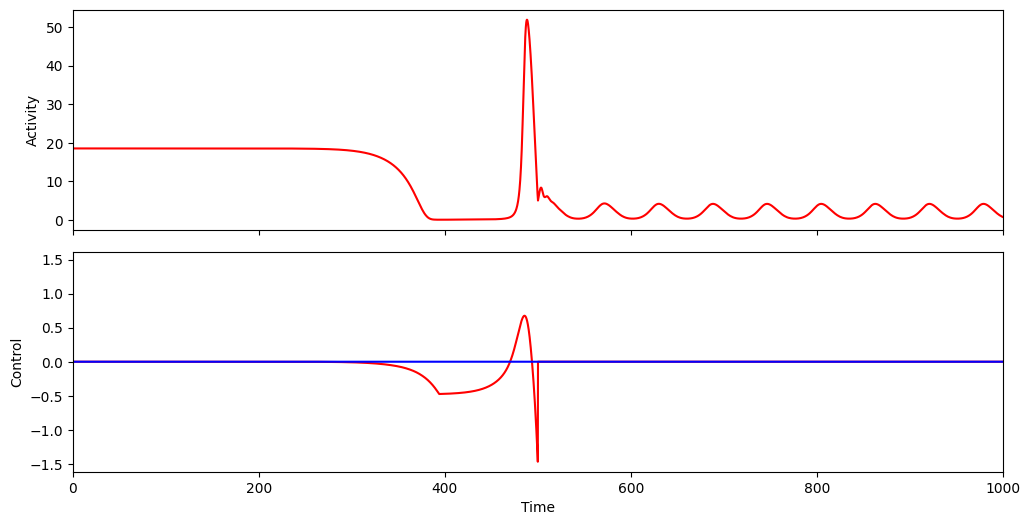

In [32]:
# rerun until convergence
ci = 0 # up to osc task

model = ALNModel()
setinitstate(model, data["init_state"][0])
model.params["mue_ext_mean"] =  data["coordinates"][0]
model.params["mui_ext_mean"] =  data["coordinates"][1]
model.params.duration = duration

model.run()

model_controlled = oc_aln.OcAln(model, natural_period, print_array=pr, cost_interval=(int1,None), control_interval=(int0, int1-1000), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = data["weights"][ci]

model_controlled.maximum_control_strength = max_cntrl

model_controlled.control = data["control"][ci].copy()
model_controlled.update_input()

model_controlled.optimize(1)

for j in range(1):
    model_controlled.grad_method = 0
    for k in np.arange(-5., 6., 4.):
        data["weights"][ci] = adjust_weight(model_controlled, data["weights"][ci])
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(5)

    model_controlled.grad_method = 1
    for k in np.arange(-5., 6., 2.):
        data["weights"][ci] = adjust_weight(model_controlled, data["weights"][ci])
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(5)

data["control"][ci] = model_controlled.control.copy()
data["state"][ci] = model_controlled.get_xs()

data["energy_input"][0] = cost_functions.control_strength_cost(data["control"][ci], weights, dt)
data["Fourier_cost"][0] = (model_controlled.compute_total_cost() - data["energy_input"][0])/data["weights"][ci]
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

In [ ]:
# shift back in time by 2 periods and reoptimize
ci = 0 # up to osc task

model = ALNModel()
setinitstate(model, data["init_state"][0])
model.params["mue_ext_mean"] =  data["coordinates"][0]
model.params["mui_ext_mean"] =  data["coordinates"][1]
model.params.duration = duration

model.run()

model_controlled = oc_aln.OcAln(model, natural_period, print_array=pr, cost_interval=(int1,None), control_interval=(int0, int1-1000), cost_matrix=costmat, control_matrix=controlmat)
model_controlled.weights["w_p"] = 0.
model_controlled.weights["w_2"] = 1.
model_controlled.weights["w_f_osc"] = data["weights"][ci]

model_controlled.maximum_control_strength = max_cntrl

model_controlled.control[0,0,:-int(2*natural_period/dt)] =  data["control"][ci].copy()[0,0,int(2*natural_period/dt):]
model_controlled.update_input()

model_controlled.optimize(0)

for j in range(5):
    model_controlled.grad_method = 0
    data["weights"][ci] = adjust_weight(model_controlled, data["weights"][ci])
    for k in np.arange(-5., 6., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(10)

    model_controlled.grad_method = 1

    for k in np.arange(-5., 6., 2.):
        model_controlled.zero_step_encountered = False
        model_controlled.step = 10**(k)
        model_controlled.optimize(10)

data["control"][ci] = model_controlled.control.copy()
data["state"][ci] = model_controlled.get_xs()

data["energy_input"][0] = cost_functions.control_strength_cost(data["control"][ci], weights, dt)
data["Fourier_cost"][0] = (model_controlled.compute_total_cost() - data["energy_input"][0])/data["weights"][ci]
plot_control(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)